In [1]:
import pandas as pd
import numpy as np
from numpy import absolute, mean, std, arange
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import xgboost
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy.stats import uniform
from itertools import product
import pickle
import time
import math
import re
import gc

import joblib
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingClassifier
from mlxtend.preprocessing import minmax_scaling

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

SEED = 123
start_0 = time.time()
%matplotlib inline

## Training Model

In [2]:
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

[]


In [3]:
for i in dir():
    if isinstance(globals()[i], pd.DataFrame):
        del globals()[i]

gc.collect()

36

#### Load Data

In [4]:
DATA_FOLDER = "./"

data = pd.read_pickle('data.pkl')
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz')) #test data

In [5]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'target', 'ID', 'city_code',
       'item_category_id', 'meta_category_code', 'subtype_code',
       'item_target_enc', 'shop_target_enc', 'item_category_target_enc',
       'city_code_target_enc', 'meta_category_code_target_enc',
       'subtype_code_target_enc', 'target_lag_1', 'target_lag_3',
       'target_lag_6', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_category_avg_item_cnt_lag_1',
       'date_shop_category_avg_item_cnt_lag_1',
       'date_shop_meta_category_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1',
       'date_meta_category_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag', 'month', 'days'],

In [6]:
data.dtypes

date_block_num                                  int64
shop_id                                         int64
item_id                                         int64
target                                        float16
ID                                            float64
city_code                                       int64
item_category_id                                int64
meta_category_code                              int64
subtype_code                                    int64
item_target_enc                               float64
shop_target_enc                               float64
item_category_target_enc                      float64
city_code_target_enc                          float64
meta_category_code_target_enc                 float64
subtype_code_target_enc                       float64
target_lag_1                                  float64
target_lag_3                                  float64
target_lag_6                                  float64
date_avg_item_cnt_lag_1     

In [7]:
#Function used to downcast
def downcast_dtypes(df):
    '''
          Changes column types in the dataframe: 
            `float64` type to `float32`
            `int64`   type to `int32`
      '''

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]

    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)

    return df
downcast_dtypes(data)

,date_block_num,shop_id,item_id,target,ID,city_code,item_category_id,meta_category_code,subtype_code,item_target_enc,shop_target_enc,item_category_target_enc,city_code_target_enc,meta_category_code_target_enc,subtype_code_target_enc,target_lag_1,target_lag_3,target_lag_6,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_meta_category_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_meta_category_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,month,days
4488710,12,2,27,0.0,0.0,1,19,5,10,0.065796,0.101196,0.989746,0.101196,0.818848,0.897949,0.0,0.0,0.0,0.470459,0.086975,0.130493,0.065247,0.156006,0.098877,0.096008,1.181641,0.965820,0.814941,0.943359,0.156006,0.0,1.125000,1.163086,-0.282715,0,31
4488711,12,2,30,0.0,0.0,1,40,11,4,3.562500,0.101196,0.263672,0.101196,0.242188,0.263672,0.0,0.0,0.0,0.470459,1.021484,0.521973,0.891113,0.156006,0.098877,0.096008,0.309082,0.046234,0.051727,0.046234,0.156006,0.0,0.281006,0.309082,-0.483398,0,31
4488712,12,2,31,0.0,0.0,1,37,11,1,2.179688,0.101196,0.198242,0.101196,0.242188,0.199829,0.0,0.0,0.0,0.470459,0.543457,0.543457,0.304443,0.156006,0.098877,0.096008,0.234009,0.059448,0.051727,0.064697,0.156006,0.0,0.281006,0.235107,-0.137451,0,31
4488713,12,2,32,1.0,0.0,1,40,11,4,2.509766,0.101135,0.263672,0.101135,0.242188,0.263672,0.0,0.0,0.0,0.470459,1.934570,1.260742,1.891602,0.156006,0.098877,0.096008,0.309082,0.046234,0.051727,0.046234,0.156006,0.0,0.281006,0.309082,-0.407227,0,31
4488714,12,2,33,1.0,0.0,1,37,11,1,0.764160,0.101196,0.198242,0.101196,0.242188,0.199829,1.0,0.0,0.0,0.470459,0.913086,0.717285,1.000000,0.156006,0.098877,0.096008,0.234009,0.059448,0.051727,0.064697,0.156006,1.0,0.281006,0.235107,-0.225464,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,inf,21,55,13,2,0.957520,0.175293,0.220215,0.181641,0.169678,0.220215,1.0,0.0,0.0,0.289307,0.045441,0.071411,0.590820,0.129639,0.139038,0.144287,0.197021,0.126831,0.089294,0.126831,0.136841,0.5,0.147095,0.197021,-0.475098,10,30
11128000,34,45,16188,0.0,inf,21,64,14,42,0.031250,0.175293,0.298096,0.181641,0.396729,0.298096,0.0,0.0,0.0,0.289307,0.022720,0.000000,0.000000,0.129639,0.000000,0.000000,0.155640,0.094482,0.112976,0.094482,0.136841,0.0,0.313232,0.155640,0.081116,10,30
11128001,34,45,15757,0.0,inf,21,55,13,2,0.227417,0.175293,0.220215,0.181641,0.169678,0.220215,0.0,0.0,0.0,0.289307,0.113647,0.095215,0.250000,0.129639,0.139038,0.144287,0.197021,0.126831,0.089294,0.126831,0.136841,0.0,0.147095,0.197021,0.155884,10,30
11128002,34,45,19648,0.0,inf,21,40,11,4,0.103699,0.175293,0.250732,0.181641,0.220825,0.250732,0.0,0.0,0.0,0.289307,0.045441,0.166626,0.090881,0.129639,0.139038,0.144287,0.221558,0.083740,0.097046,0.083740,0.136841,0.0,0.226318,0.221558,-0.091736,10,30


In [8]:
data["target"] = data["target"].astype(np.float64)

In [9]:
data.dtypes

date_block_num                                  int16
shop_id                                         int16
item_id                                         int16
target                                        float64
ID                                            float16
city_code                                       int16
item_category_id                                int16
meta_category_code                              int16
subtype_code                                    int16
item_target_enc                               float16
shop_target_enc                               float16
item_category_target_enc                      float16
city_code_target_enc                          float16
meta_category_code_target_enc                 float16
subtype_code_target_enc                       float16
target_lag_1                                  float16
target_lag_3                                  float16
target_lag_6                                  float16
date_avg_item_cnt_lag_1     

#### Split Data into Train Val and Test Set (Tree Based Model)

In [10]:
%%time
data.pop('ID')
X_train = data[data.date_block_num < 33].drop(['target'], axis=1)
y_train = data[data.date_block_num < 33]['target']
X_val = data[data.date_block_num == 33].drop(['target'], axis=1)
y_val = data[data.date_block_num == 33]['target']
X_test = data[data.date_block_num == 34].drop(['target'], axis=1)

Wall time: 2.57 s


In [11]:
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

['X_test', 'X_train', 'X_val', '_7', '__', 'data', 'test']


#### Train Initial lightGBM Model

In [12]:
%%time
lgb_params = {
               'metric': 'rmse',
               'objective': 'mse', 
               'nthread':-1, 
               'bagging_seed': SEED, 
               'feature_fraction': 0.75,
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'num_leaves': 2**7, 
               'reg_alpha': 1.0,
               'reg_lambda': 1.0,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.766565 seconds.
You can set `force_col_wise=true` to remove the overhead.
Wall time: 36.6 s


In [13]:
# Save the model as a pickle in a file
joblib.dump(model, 'lgb_model.pkl')

filename = 'lgb_model.sav'
pickle.dump(model, open(filename, 'wb'))

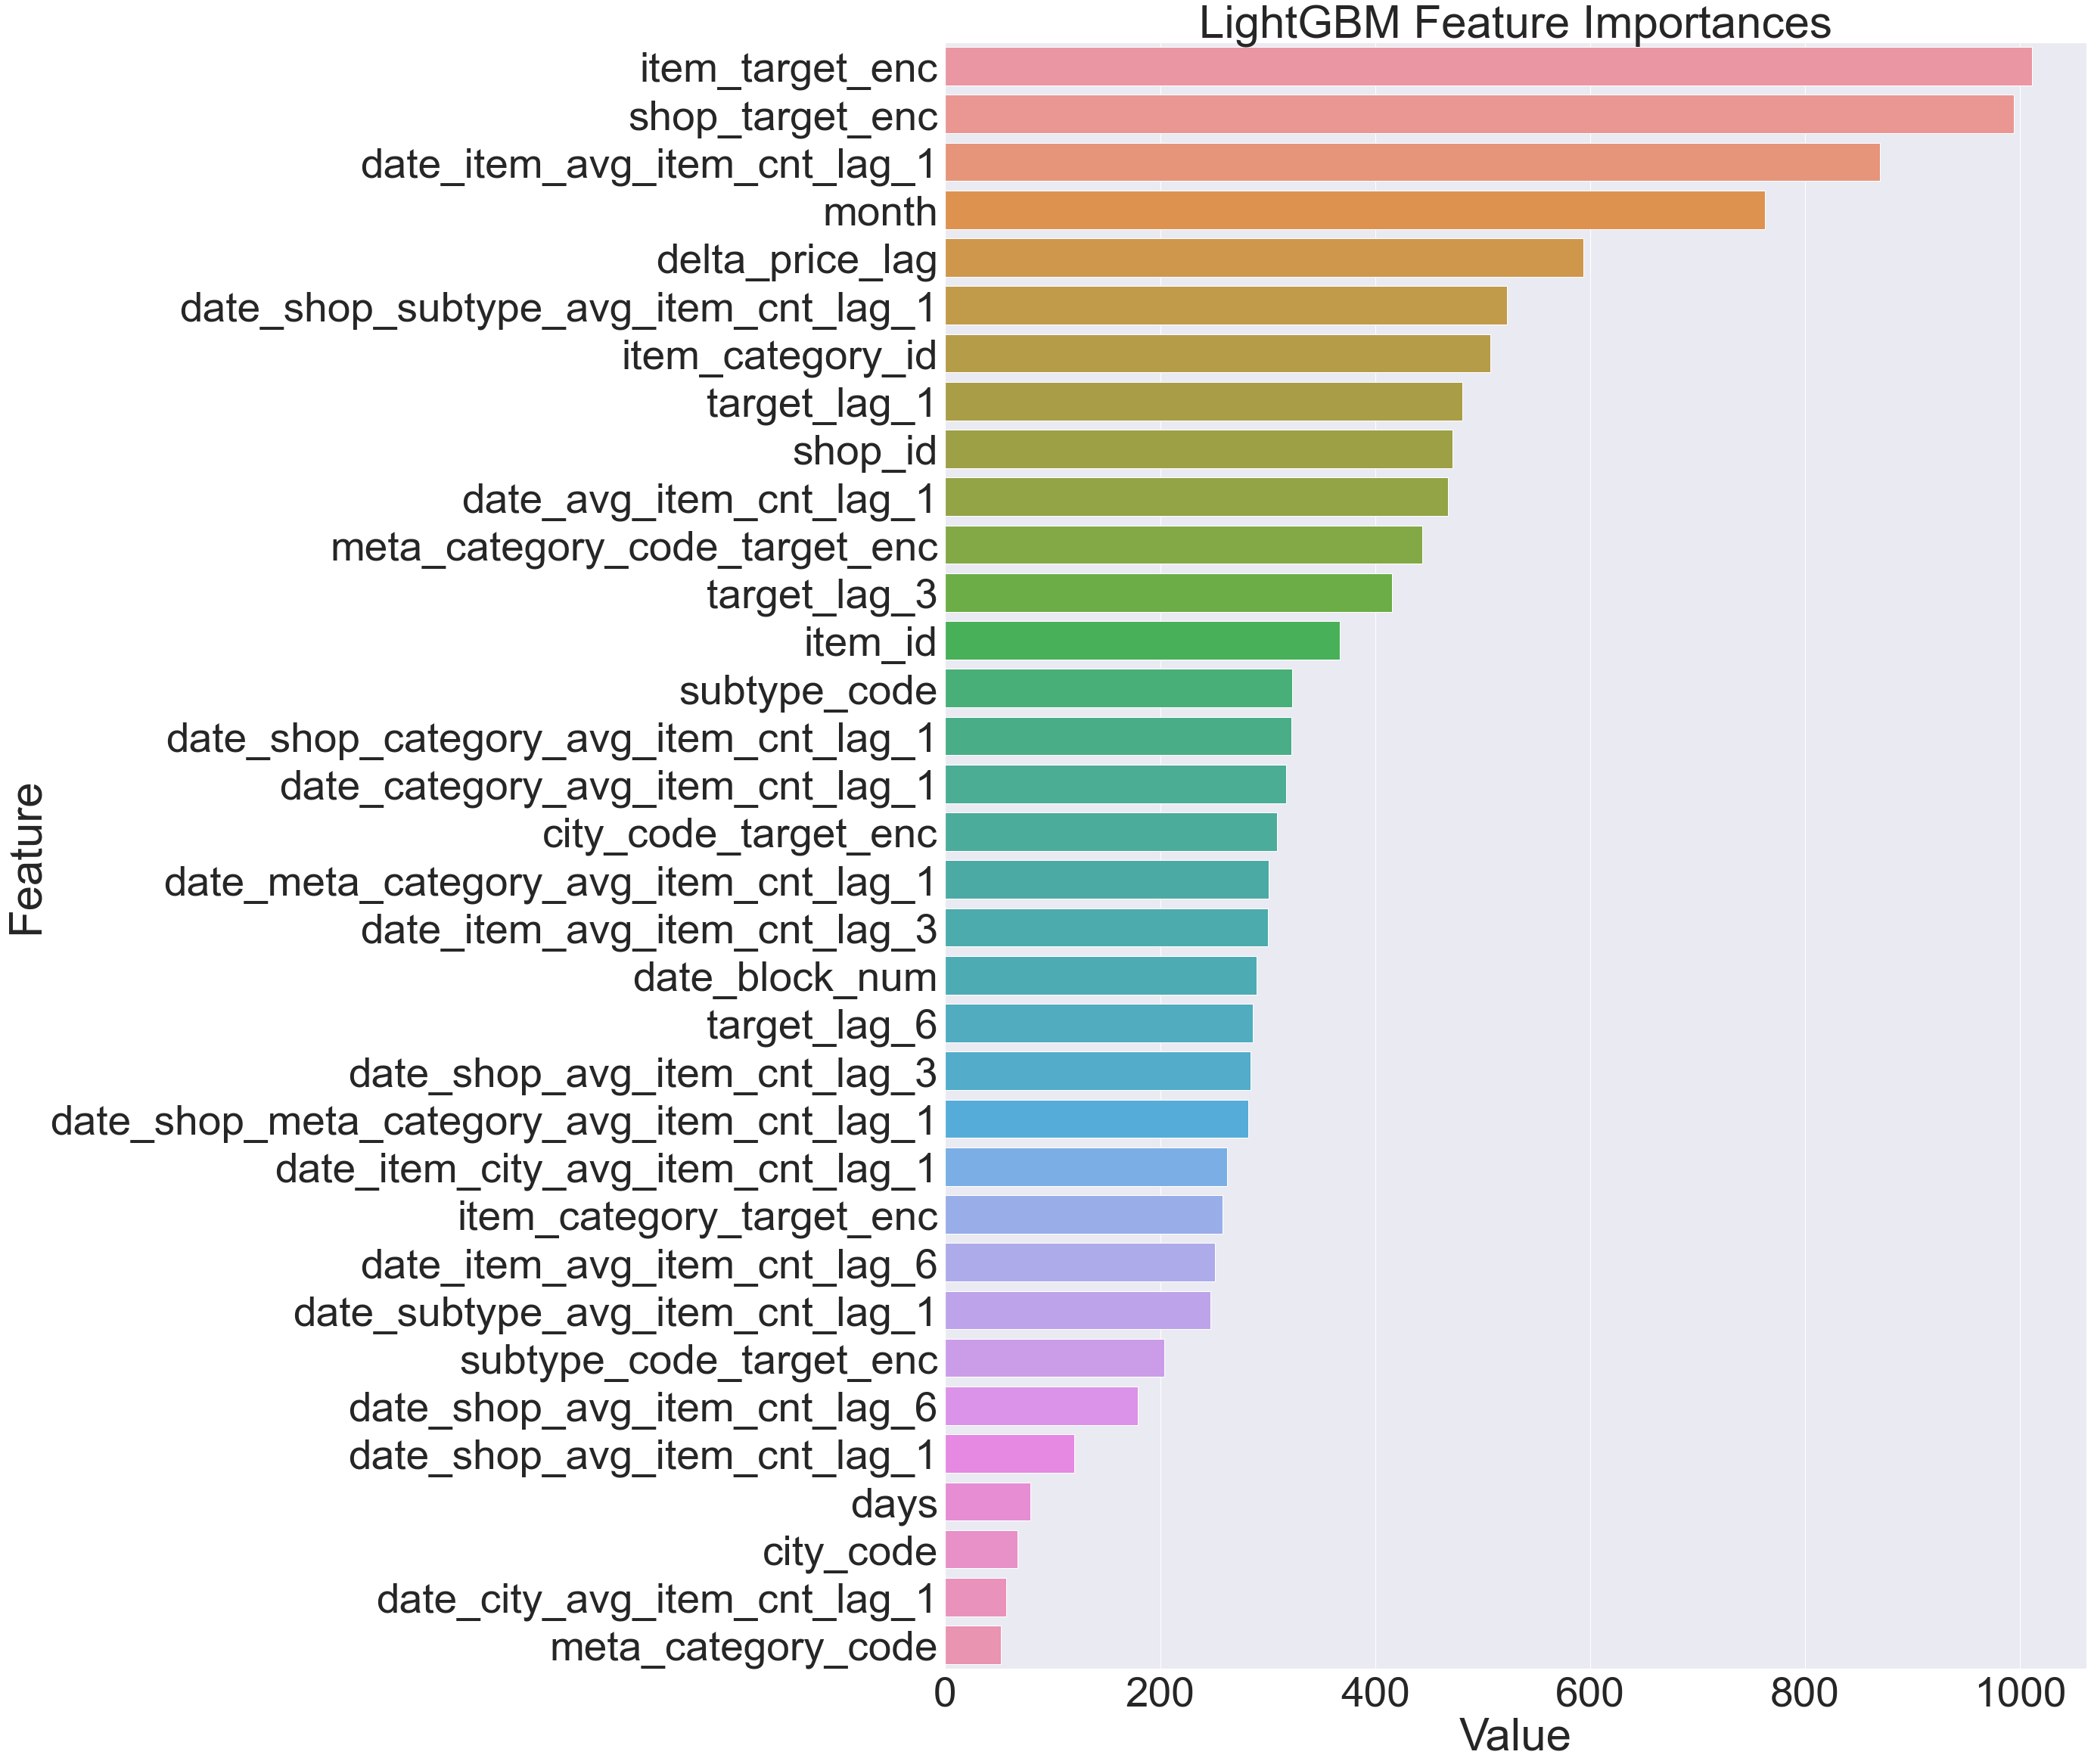

In [14]:
# Feature importances

def plotImp(model, X , num = 25, fig_size = (50, 25),importance_type='split'):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type=importance_type),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Feature Importances')
    plt.tight_layout()
    plt.show()
    
plotImp(model, X_train, num = X_train.shape[1], fig_size = (40, X_train.shape[1]),importance_type='split')

In [15]:
model = LGBMRegressor()

gridParams = {
    'learning_rate': [0.005, 0.1],
    'num_leaves': [50,2**7],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2],
    'feature_fraction': [0.75],
    'min_data_in_leaf': [2**7], 
    'bagging_fraction': [0.75], 
    'num_leaves': [2**7], 
    'reg_alpha': [1.0],
    'reg_lambda': [1.0],
    'bagging_freq':[1],
}

# Create the grid
grid = GridSearchCV(model, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)
 
# Using parameters already set above, replace in the best from the grid search
lgb_params['learning_rate'] = grid.best_params_['learning_rate']
lgb_params['num_leaves'] = grid.best_params_['num_leaves']
lgb_params['reg_alpha'] = grid.best_params_['reg_alpha']
lgb_params['reg_lambda'] = grid.best_params_['reg_lambda']

print('Fitting with params: ')
print(lgb_params)

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
{'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.75, 'learning_rate': 0.1, 'min_data_in_leaf': 128, 'num_leaves': 128, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
0.5770922560174958
Fitting with params: 
{'metric': 'rmse', 'objective': 'mse', 'nthread': -1, 'bagging_seed': 123, 'feature_fraction': 0.75, 'min_data_in_leaf': 128, 'bagging_fraction': 0.75, 'learning_rate': 0.1, 'num_leaves': 128, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'bagging_freq': 1, 'verbose': 0}
[LightGBM] [Warning] Auto-choosing col-wise 

In [16]:
%%time
y_pred = model.predict(X_val).clip(0, 20)
print('y_pred shape is:', y_pred.shape)

# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(y_pred, y_val) ** 0.5, 5))

# save predictions for an ensemble
pickle.dump(y_pred, open('lgb_val.pickle', 'wb'))

y_pred shape is: (238172,)
The rmse of prediction is: 0.8507
Wall time: 520 ms


In [17]:
%%time
y_test = model.predict(X_test).clip(0, 20)
print('y_test shape is:', y_test.shape)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('Final_Project_lightGBM_submission_v3.csv', index=False)

# save predictions for submission
pickle.dump(y_test, open('lgb_test.pickle', 'wb'))

y_test shape is: (214200,)
Wall time: 981 ms


In [18]:
print('It takes %s minutes' % ((time.time() - start_0)/60))

It takes 5.500161151091258 minutes
